In [13]:
import os
import pandas as pd
import numpy as np
import pypsa
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [15]:
modelpath = Path.cwd() / '..' / 'results' / "basic_test" / "postnetworks"
datapath = Path.cwd() / ".." / ".." / "cluster_results" / "useful_networks"

In [88]:
nodal_caps = pd.read_csv(
    datapath / "expand_data" / "nodal_capacities.csv",
    index_col=[0,1,2],
    header=[0,1,2,3,4,5,6]
    )
print(nodal_caps.columns.get_level_values(6))

buses = nodal_caps.index.get_level_values(1).unique().dropna()
buses = buses[~buses.str.contains("EU")]
buses = buses[~buses.isin(['gas for', 'process', 'solid'])]

nodal_caps = nodal_caps.loc[:,buses,:,:]

idx = pd.IndexSlice

totals = nodal_caps.groupby(level=[0,1]).sum()

nodal_caps = nodal_caps.div(totals.reindex(nodal_caps.index, method='ffill'))

Index(['static', 'flex'], dtype='object', name='egs_op')


##### Based on new summaries

In [61]:
import os
import sys
import pypsa
from copy import deepcopy
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import geopandas as gpd
import pycountry
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from matplotlib.cm import get_cmap
from pandas import IndexSlice

idx = IndexSlice

from region_grouper import coarse_regions

data_path = Path.cwd().parent.parent.parent / "cluster_data"
regions = gpd.read_file(data_path / "resources" / "regions_onshore_elec_s_72.geojson")
regions = regions.set_index("name")
regions["name"] = regions.index

plot_regions = [
    'Northern Spain',
    'Sweden',
    'England',
    'Poland',
    'Norway',
    'Finland',
    'Central Germany',
    'Northern France',
    'Ireland',
    'Romania',
    'Southern France',
    'Central Italy',
    'Netherlands',
    'Scotland',
    'Belgium',
    ]
cmap = get_cmap("tab20b")
colors = cmap.colors[::-1]


def dict_list(dict):
    aslist = list()

    for value in dict.values():
        aslist += value

    return aslist

def make_region_mapper():

    result = deepcopy(coarse_regions)
    covered = dict_list(result)

    for bus in regions.index:

        if bus in covered:
            continue

        result[pycountry.countries.get(alpha_2=bus[:2]).name] = [bus]

    return result

mapper = make_region_mapper()
reverse_mapper = dict()

for key, values in mapper.items():
    for value in values:
        reverse_mapper[value] = key

regions["region"] = regions["name"].apply(lambda entry: reverse_mapper[entry])
regions

bus_colors = {bus: "gray" for bus in list(reverse_mapper)}

for region, color in zip(plot_regions, colors):
    for bus in mapper[region]:
        bus_colors[bus] = color

In [3]:
# file = Path.cwd().parent.parent.parent / "cluster_data" / "joint data" / "nodal_geothermal_stats_1500_chp_dh.csv"
file = Path.cwd().parent.parent.parent / "cluster_data" / "dh_data" / "csvs_static" / "nodal_geothermal_stats.csv"

In [17]:
n = pypsa.Network(
    Path.cwd().parent.parent.parent /
    "cluster_data" /
    "dh_data" /
    "elec_s_72_lv1.0__Co2L0-3H-T-H-B-I-solar+p3-dist1_2030_3000_dh_static_0.3.nc"
)

INFO:pypsa.io:Imported network elec_s_72_lv1.0__Co2L0-3H-T-H-B-I-solar+p3-dist1_2030_3000_dh_static_0.3.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [15]:
df = pd.read_csv(file, index_col=[0,1], header=[4,5,6,7]).loc[:,idx['3000',:,:,:]].unstack().fillna(0)
df.columns = df.columns.get_level_values(-1)
df

,dac,geothermal generation share,geothermal heat dh,offwind-ac,offwind-dc,onwind,solar
location,,,,,,,
AL1 0,59.531291,0.003092,0.037881,0.126154,0.000000,0.058108,0.153365
AT1 0,45.354770,0.902536,1782.383595,0.000000,0.000000,0.130349,0.120172
BA1 0,45.714599,0.854413,148.642519,0.000000,0.000000,0.046744,0.133218
BE1 0,0.003616,0.655518,1724.970996,0.418017,0.456600,0.289580,0.109719
BG1 0,457.689891,0.918632,1427.690743,0.205341,0.214824,0.128927,0.146461
...,...,...,...,...,...,...,...
RS1 0,409.824720,0.894633,1504.983410,0.000000,0.000000,0.106817,0.136783
SE2 0,7142.354533,0.931099,17410.904705,0.351832,0.436903,0.235716,0.111970
SE2 1,25.822921,0.761620,68.644504,0.334124,0.427989,0.196635,0.102921


In [38]:
df["borehole_cap"] = n.links.loc[df.index + " geothermal injection well", "p_nom_opt"].values
df["electrolyer_cap"] = n.links.loc[n.links.carrier == "H2 Electrolysis", "p_nom_opt"].values
df["dac_cap"] = n.links.loc[df.index + " urban central DAC", "p_nom_opt"].values
# df["urban central heat demand"] = n.loads.p_set.loc[:, df.index + " urban central heat"].sum().values
uch = (hold := n.loads_t.p_set).loc[:, (df.index + " urban central heat").intersection(hold.columns)].sum()
uch.index = uch.index.str[:5]
uch = uch.reindex(df.index, fill_value=0)
df["urban central heat demand"] = uch

df


,dac,geothermal generation share,geothermal heat dh,offwind-ac,offwind-dc,onwind,solar,borehole_cap,electrolyer_cap,dac_cap,urban central heat demand
location,,,,,,,,,,,
AL1 0,59.531291,0.003092,0.037881,0.126154,0.000000,0.058108,0.153365,0.047458,7441.269064,59.531291,1.464086e+05
AT1 0,45.354770,0.902536,1782.383595,0.000000,0.000000,0.130349,0.120172,2227.979593,2791.653580,45.354770,5.915261e+06
BA1 0,45.714599,0.854413,148.642519,0.000000,0.000000,0.046744,0.133218,185.803253,427.129124,45.714599,3.664516e+05
BE1 0,0.003616,0.655518,1724.970996,0.418017,0.456600,0.289580,0.109719,2156.213857,3389.284853,0.003616,6.930636e+06
BG1 0,457.689891,0.918632,1427.690743,0.205341,0.214824,0.128927,0.146461,1784.613543,15720.338546,457.689891,2.320336e+06
...,...,...,...,...,...,...,...,...,...,...,...
RS1 0,409.824720,0.894633,1504.983410,0.000000,0.000000,0.106817,0.136783,1881.229367,907.097331,409.824720,3.172666e+06
SE2 0,7142.354533,0.931099,17410.904705,0.351832,0.436903,0.235716,0.111970,21763.631015,456.314938,7142.354533,1.424744e+07
SE2 1,25.822921,0.761620,68.644504,0.334124,0.427989,0.196635,0.102921,85.805781,46.557980,25.822921,3.120267e+04


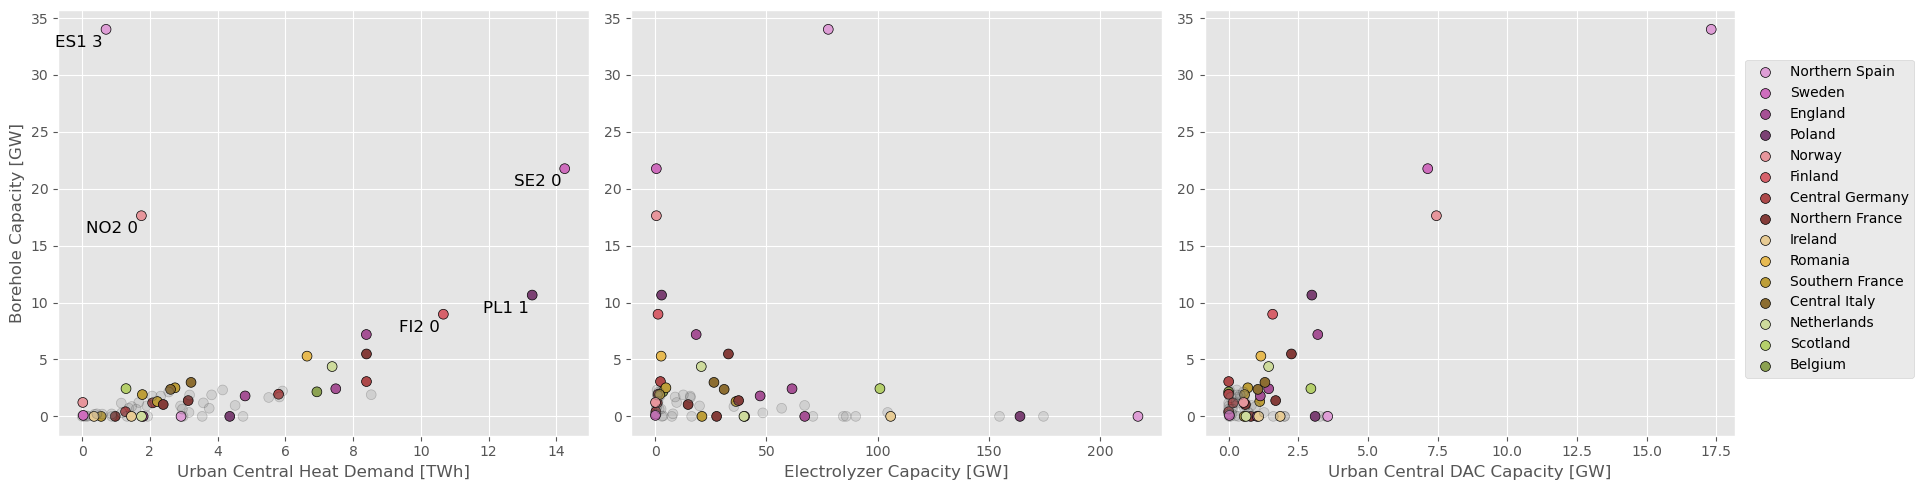

In [84]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5))

y_pts = df["borehole_cap"] * 1e-3
colors = [bus_colors[bus] for bus in df.index]
alphas = list(map(lambda c: 0.2 if c == "gray" else 1, colors))

scatter_kwargs = {"s": 50, "edgecolor": 'k', "color": colors, "alpha": alphas}

axs[0].scatter(df["urban central heat demand"] * 1e-6, y_pts, **scatter_kwargs)
axs[1].scatter(df["electrolyer_cap"] * 1e-3, y_pts, **scatter_kwargs)
axs[2].scatter(df["dac_cap"] * 1e-3, y_pts, **scatter_kwargs)

for ax, l in zip(axs, ["Urban Central Heat Demand [TWh]" , "Electrolyzer Capacity [GW]", "Urban Central DAC Capacity [GW]"]):
    ax.set_xlabel(l)

axs[0].set_ylabel("Borehole Capacity [GW]")

handles = []
for region, color in zip(plot_regions, cmap.colors[::-1]):
    handles.append(plt.scatter([], [], color=color, label=region, s=50, edgecolor='k'))

axs[-1].legend(
    handles=handles,
    # loc="upper left")
    bbox_to_anchor=(1.35, 0.9),
    fancybox=True,
    shadow=False,
    ncol=1,
)

n_text = 5
text_df = df.sort_values(by="borehole_cap", ascending=False).head(n_text)

text = text_df.index
text_x = text_df["urban central heat demand"] * 1e-6
text_y = text_df["borehole_cap"] * 1e-3

for t, x, y in zip(text, text_x, text_y):
    axs[0].text(
        x-0.1,
        y-0.5,
        t,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='right',
        color='black'
    )


plt.tight_layout()
plt.show()


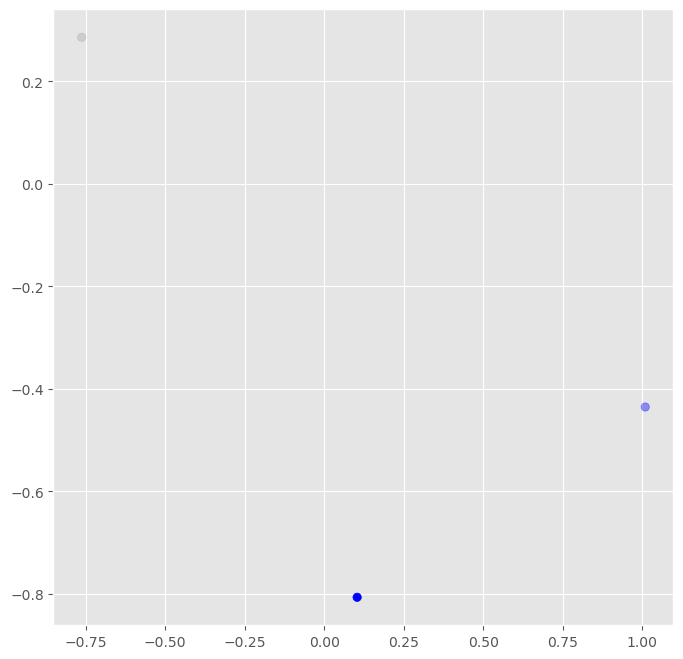

In [80]:
a = pd.DataFrame(np.random.normal(size=(3, 2)), index=["a", "b", "c"], columns=["x", "y"])
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(a["x"], a["y"], color=["k", "b", "b"], alpha=[0.1, 1, 0.4])
plt.show()

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [5]:
print(df.index.get_level_values(1).unique())

Index(['dac', 'geothermal generation share',
       'geothermal heat chp district heat', 'geothermal heat chp elec',
       'geothermal heat dh', 'offwind-ac', 'onwind', 'solar', 'offwind-dc'],
      dtype='object')


Index(['dac', 'geothermal generation share',
       'geothermal heat chp district heat', 'geothermal heat chp elec',
       'geothermal heat dh', 'offwind-ac', 'onwind', 'solar', 'offwind-dc'],
      dtype='object')


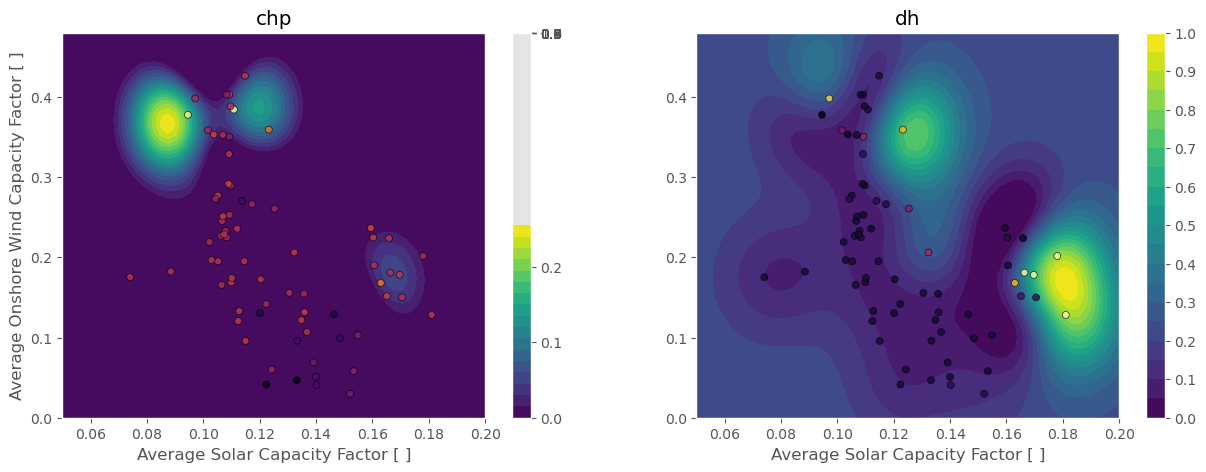

In [9]:
mode = "dh"

print(df.index.get_level_values(1).unique())

# quants = ["geothermal generation share", "dac", "onwind", "solar"]
# df.loc[idx[:, []], idx[mode]]
# df

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

scatter_kwargs = dict(
    s=25,
    alpha=0.8,
    edgecolors="k",
    cmap="inferno",
)

def get_contour(X, y, n=400):

    # model = GaussianProcessRegressor(kernel=C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3)), n_restarts_optimizer=9)
    model = SVR(gamma=2, C=1)

    scaler = StandardScaler()
    model = model.fit(scaler.fit_transform(X), y)

    plot_x = np.linspace(0., 1., n)
    plot_y = np.linspace(0., 1., n)

    plot_x, plot_y = np.meshgrid(plot_x, plot_y)

    plot_x = plot_x.flatten()
    plot_y = plot_y.flatten()

    plot_X = np.vstack((plot_x, plot_y)).T

    plot_z = model.predict(scaler.transform(plot_X))

    plot_x = plot_X[:,0]
    plot_y = plot_X[:,1]

    plot_x = plot_x.reshape(n, n)
    plot_y = plot_y.reshape(n, n)
    plot_z = plot_z.reshape(n, n)

    return plot_x, plot_y, plot_z



for ax, mode in zip(axs, ["dh", "chp"][::-1]):

    wind = df.loc[idx[:, ["onwind"]], idx[mode, "flex"]]
    solar = df.loc[idx[:, ["solar"]], idx[mode, "flex"]]

    diff = df.loc[idx[:, "geothermal generation share"], idx[mode, "flex"]] - df.loc[idx[:, "geothermal generation share"], idx[mode, "static"]]

    ax.set_xlabel("Average Solar Capacity Factor [ ]")

    X = np.vstack((solar.values, wind.values)).T
    y = diff.values.flatten()

    cx, cy, cz = get_contour(X, y, n=400)

    cbar = ax.contourf(
        cx,
        cy,
        cz.clip(0., 1.),
        cmap="viridis",
        # vmin=0.,
        # vmax=1.,
        levels=20,
        # alpha=0.5
        )

    cbar = fig.colorbar(cbar, ax=ax)#, vmin=0., vmax=1.)
    v = np.linspace(0., 1., 11, endpoint=True)
    cbar.set_ticks(v)

    # ax.clabel(cbar, inline=True, fontsize=8)
    # ax.contourf(plot_x, plot_y, plot_y, cmap="plasma")

    ax.scatter(solar, wind, c=diff, **scatter_kwargs)
    ax.set_xlim(0.05, 0.2)
    ax.set_ylim(0.0, 0.48)

    ax.set_title(mode)

# plt.colorbar(cax=)
    # break

# for ax in axs:
# ax.legend()

axs[0].set_ylabel("Average Onshore Wind Capacity Factor [ ]")

plt.show()

<AxesSubplot:xlabel='location'>

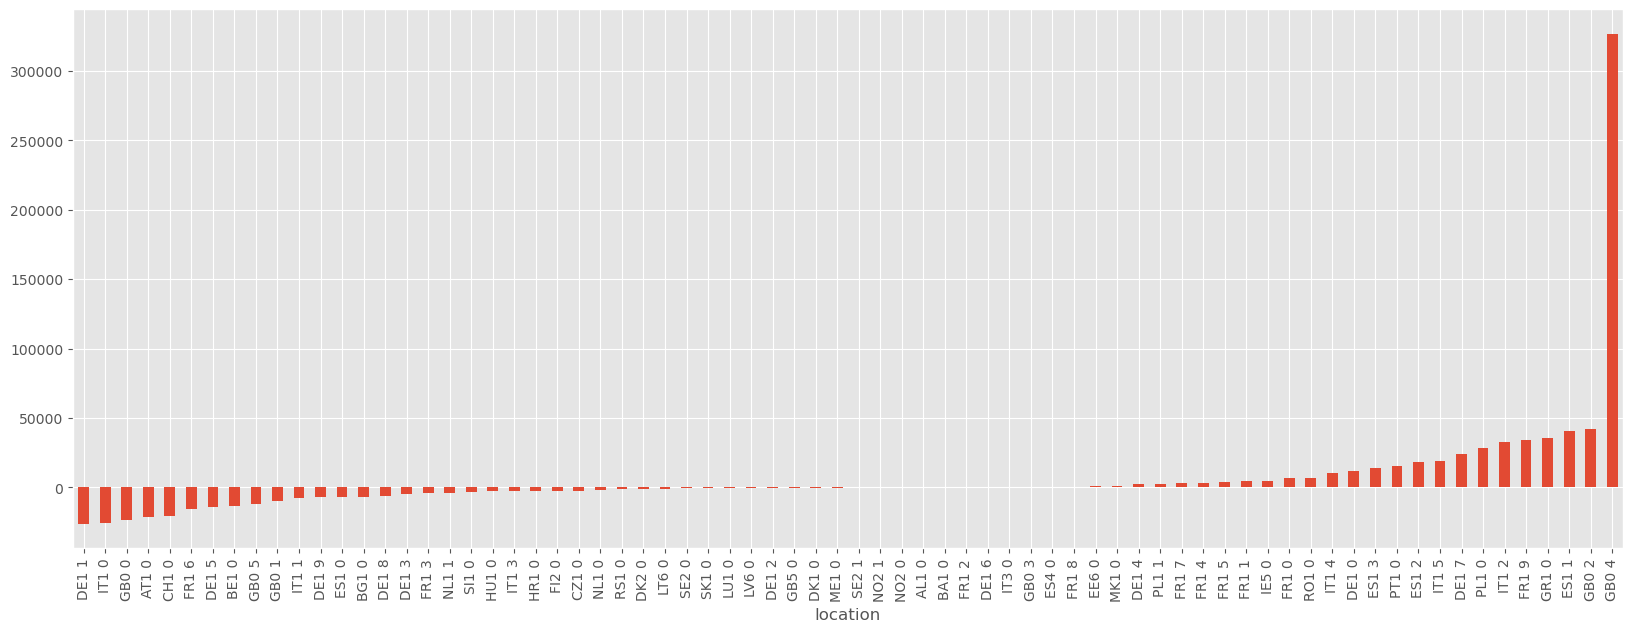

In [147]:
mode = "chp"

quant = "geothermal heat chp district heat"
diff = df.loc[idx[:, quant], idx[mode, "flex"]] - df.loc[idx[:, quant], idx[mode, "static"]]
diff.index = diff.index.get_level_values(0)

fig, ax = plt.subplots(1, 1, figsize=(20, 7))

diff.sort_values().plot.bar(ax=ax)


In [150]:
diff

location
AL1 0       13.497271
AT1 0   -21619.211527
BA1 0      123.082483
BE1 0   -13015.796638
BG1 0    -6587.527110
             ...     
RS1 0    -1277.949844
SE2 0     -718.610517
SE2 1      -13.325179
SI1 0    -3276.986810
SK1 0     -716.728630
Length: 72, dtype: float64

                                                geometry      diff
name                                                              
AL1 0  POLYGON ((20.32207 39.91318, 20.39703 39.81809...  0.072029
AT1 0  POLYGON ((13.86068 46.51525, 13.67026 46.51871...  0.515766
BA1 0  POLYGON ((17.82716 42.85312, 17.81176 42.90986...  0.605884
BE1 0  POLYGON ((4.68192 50.08392, 4.67292 50.01638, ...  0.674800
BG1 0  POLYGON ((23.94989 41.43758, 23.89480 41.46434...  0.676737
...                                                  ...       ...
RS1 0  POLYGON ((20.75050 41.90680, 20.72331 41.86662...  0.841982
SE2 0  MULTIPOLYGON (((12.97918 55.40327, 12.83277 55...  0.430447
SE2 1  MULTIPOLYGON (((17.49916 61.72383, 17.45725 61...  0.010858
SI1 0  POLYGON ((15.60435 46.16700, 15.58988 46.11352...  0.737373
SK1 0  POLYGON ((17.61911 47.82923, 17.57260 47.82954...  0.855802

[72 rows x 2 columns]


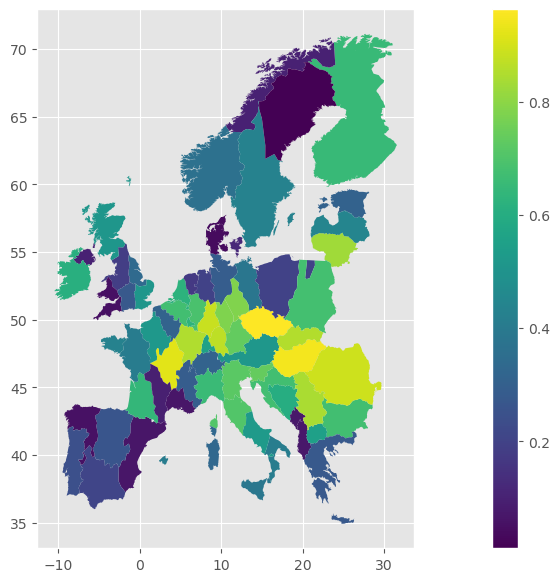

egs_mode                                             dh               \
egs_op                                           static         flex   
location                                                               
AL1 0    dac                                  22.310998    27.288587   
         geothermal generation share           0.000181     0.008956   
         geothermal heat chp district heat     0.000000     0.000000   
         geothermal heat chp elec              0.000000     0.000000   
         geothermal heat dh                    0.037401     2.997847   
...                                                 ...          ...   
SK1 0    geothermal heat chp district heat     0.000000     0.000000   
         geothermal heat chp elec              0.000000     0.000000   
         geothermal heat dh                 1789.534604  1820.798346   
         onwind                                0.141757     0.141757   
         solar                                 0.122296     0.12

In [160]:
import geopandas as gpd
shapes = gpd.read_file(Path.cwd().parent.parent.parent / "cluster_data" / "resources" / "regions_onshore_elec_s_72.geojson")
shapes = shapes.set_index("name")
shapes["diff"] = diff
mode = "chp"
# quant = "geothermal heat chp district heat"

quant = 'geothermal generation share'
diff = df.loc[idx[:, quant], idx[mode, "flex"]]#  - df.loc[idx[:, quant], idx[mode, "static"]]
diff.index = diff.index.get_level_values(0)

fig, ax = plt.subplots(1, 1, figsize=(20, 7))

print(shapes)
shapes.plot(column="diff", ax=ax, legend=True)
plt.show()

print(df)
